Loo site. 

# Process input data
> This part mainly load dataset, and construct train & test dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
from scipy.stats import pearsonr

from CausalLSTM.data import load_and_qc_data

np.random.seed(1)
tf.compat.v1.set_random_seed(13)

site_name = 'Blo'
ROOT = '/hard/lilu/Fluxnet/'#'/Users/lewlee/Desktop/'
PATH = ROOT + 'FLX_US-Blo_FLUXNET2015_FULLSET_DD_1997-2007_1-3.csv'

#'FLX_FI-Sod_FLUXNET2015_FULLSET_DD_2001-2014_1-3.csv'
#'FLX_NL-Loo_FLUXNET2015_FULLSET_DD_1996-2013_1-3.csv'
#'FLX_AU-DaP_FLUXNET2015_FULLSET_DD_2007-2013_2-3.csv'
#'FLX_CH-Lae_FLUXNET2015_FULLSET_DD_2004-2014_1-3.csv'
#'FLX_ZA-Kru_FLUXNET2015_FULLSET_DD_2000-2010_1-3.csv'
#'FLX_US-Blo_FLUXNET2015_FULLSET_DD_1997-2007_1-3.csv'
#'FLX_NL-Loo_FLUXNET2015_FULLSET_DD_1996-2013_1-3.csv'
#'LW_IN_F_MDS'

df, label = load_and_qc_data(
    PATH=PATH, 
    feature_params=['TA_F_MDS','SW_IN_F_MDS','P_F','PA_F','VPD_F_MDS','CO2_F_MDS','WS_F','TS_F_MDS_1','SWC_F_MDS_1'],#'SW_OUT','LW_OUT', 
    label_params=['SWC_F_MDS_1'], 
    qc_params=['SWC_F_MDS_1_QC']
)

2.1.0


Prepare int forcing data of fluxnet data of CoLM

In [2]:
print('The simple describe of dataset is {}:'.format(len(label)))
print('The num of nan is {}'.format(np.sum(np.isnan(label))))
df.describe().transpose()

The simple describe of dataset is 3786:
The num of nan is SWC_F_MDS_1    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
TA_F_MDS,3786.0,12.094890,7.222576,-5.960,6.34250,12.1930,18.97650,27.295
SW_IN_F_MDS,3786.0,218.915270,109.967503,5.188,121.53575,230.7580,327.44175,392.086
VPD_F_MDS,3786.0,8.934378,5.937123,0.426,3.49900,7.8300,13.76700,28.508
PA_F,3786.0,86.729951,0.375342,84.735,86.52400,86.7490,86.95600,87.989
P_F,3786.0,3.741513,10.870197,0.000,0.00000,0.0000,0.25400,132.588
WS_F,3786.0,1.613937,0.631981,0.505,1.23500,1.4625,1.77500,5.964
CO2_F_MDS,3786.0,375.979851,6.802714,349.285,372.46250,376.3155,380.46275,410.586
TS_F_MDS_1,3786.0,10.715637,6.461987,0.323,4.72800,10.5520,16.55875,24.782
SWC_F_MDS_1,3786.0,21.841896,10.411855,5.306,11.56025,23.4910,31.58275,42.289


<BarContainer object of 3786 artists>

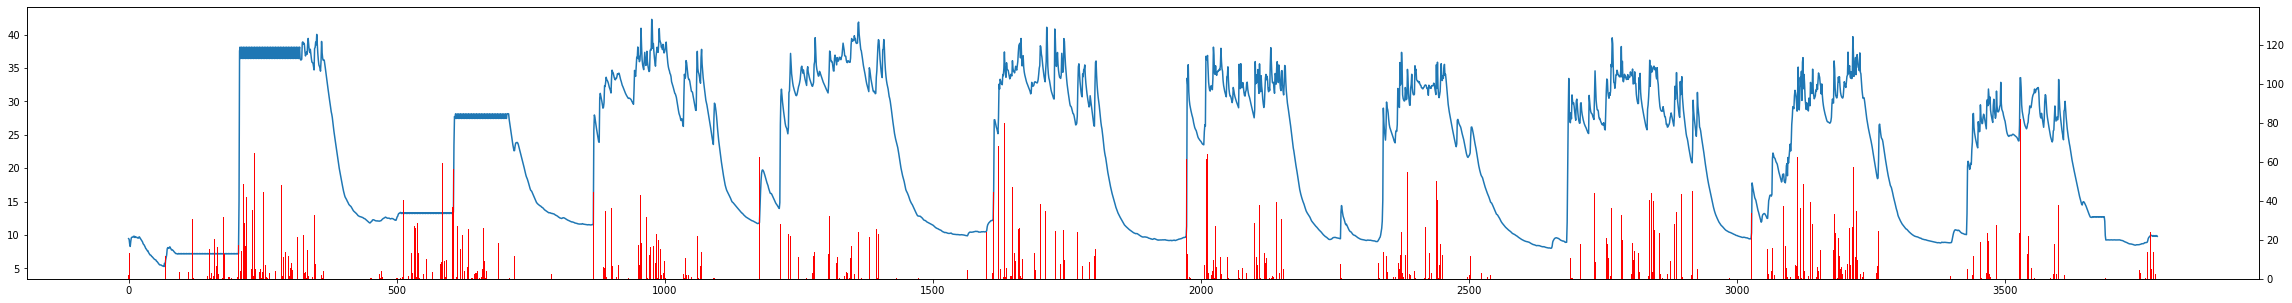

In [3]:
# select manully
fig = plt.figure(figsize=(40,5))

n = len(df)

ax = plt.subplot(111)
plt.plot(np.arange(n), df['SWC_F_MDS_1'])

ax1 = ax.twinx()
ax1.bar(x=np.arange(n), height=df['P_F'], color='red')

In [5]:
from CausalLSTM.tree_causality import CausalTree

ct = CausalTree(num_features=9,
           name_features=['TA_F_MDS','SW_IN_F_MDS','P_F','PA_F','VPD_F_MDS','CO2_F_MDS','WS_F','TS_F_MDS_1','SWC_F_MDS_1'],
           corr_thresold=0.5,
           mic_thresold=0.5,
           flag=[1,1,0])
adjacency_matrix, tree, children, child_input_idx, child_state_idx = ct(np.array(df))

print(adjacency_matrix[:, :])
print(tree)
print(children)
print(child_input_idx)
print(child_state_idx)

[[1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 1.]]
[[1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 1.]]
[[0, 2, 7]]
{'1': [[8]], '2': [[0, 2, 7]], '3': [[1, 2, 7, 8], [0, 1, 7, 8], [0, 1, 2, 8]]}
[[1], [2], [7], [8], [0], [1], [7], [8], [0], [1], [2], [8], [0], [2], [7], [8]]


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

print(column_indices)
print('length of train dataset is {}'.format(len(train_df)))
print('length of test dataset is {}'.format(len(test_df)))

{'TA_F_MDS': 0, 'SW_IN_F_MDS': 1, 'VPD_F_MDS': 2, 'PA_F': 3, 'P_F': 4, 'WS_F': 5, 'CO2_F_MDS': 6, 'TS_F_MDS_1': 7, 'SWC_F_MDS_1': 8}
length of train dataset is 3028
length of test dataset is 758


In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

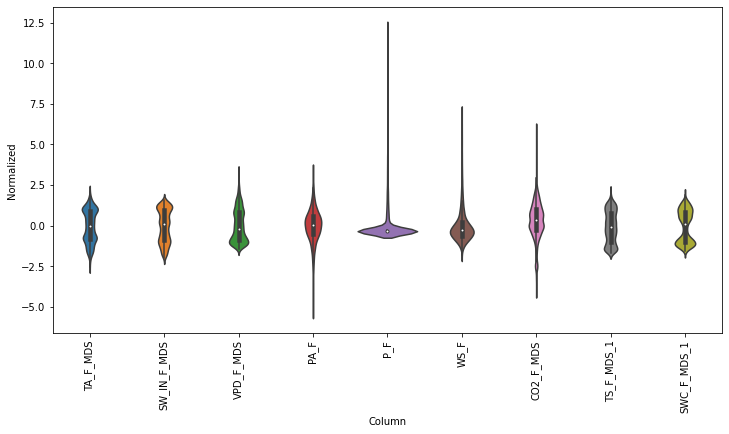

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [10]:
def generate(inputs, outputs,
             len_input, len_output, window_size):
    """Generate inputs and outputs for SMNET."""
    # caculate the last time point to generate batch
    end_idx = inputs.shape[0] - len_input - len_output - window_size
    # generate index of batch start point in order
    batch_start_idx = range(end_idx)
    # get batch_size
    batch_size = len(batch_start_idx)
    # generate inputs
    input_batch_idx = [
        (range(i, i + len_input)) for i in batch_start_idx]
    inputs = np.take(inputs, input_batch_idx, axis=0). \
        reshape(batch_size, len_input,
                inputs.shape[1])
    # generate outputs
    output_batch_idx = [
        (range(i + len_input + window_size, i + len_input + window_size +
               len_output)) for i in batch_start_idx]
    outputs = np.take(outputs, output_batch_idx, axis=0). \
        reshape(batch_size,  len_output,
                outputs.shape[1])
    return inputs, outputs

In [11]:
train_x , train_y = generate(train_df.values[:,:], train_df.values[:,-1][:, np.newaxis], 10, 1, 7)
test_x, test_y = generate(test_df.values[:,:], test_df.values[:,-1][:, np.newaxis], 10, 1, 7)

print('the shape of train dataset is {}'.format(train_x.shape))
print('the shape of test dataset is {}'.format(test_x.shape))

the shape of train dataset is (3010, 10, 9)
the shape of test dataset is (740, 10, 9)


## Casuality LSTM vs LSTM
> **tensorflow edition**

In [14]:
train_x = train_x[:3000]
train_y = train_y[:3000]
test_x = test_x[:700]
test_y = test_y[:700]

batch_size = 50

In [26]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(train_x.reshape(-1, 90), train_y.reshape(-1,1))
y_pred_rf = model.predict(test_x.reshape(-1, 90))
print('r2 of test dataset is {}'.format(
    r2_score(np.squeeze(y_pred_rf), np.squeeze(test_y))))


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor()

r2 of test dataset is 0.8568367095198451


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath='/Users/lewlee/Desktop/log/',
                             monitor = 'val_loss',
                             save_best_only='True',
                             save_weights_only='True')
                             
lr = ReduceLROnPlateau(monitor='val_loss', 
                  factor=0.1, 
                  patience=10, 
                  verbose=0, 
                  mode='auto', 
                  epsilon=0.0001, 
                  cooldown=0, 
                  min_lr=0)

In [17]:
model = LSTM(16, batch_size)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=['mse'])
history = model.fit(train_x, np.squeeze(train_y), batch_size=batch_size, epochs=50, validation_split=0.2,callbacks=[checkpoint,lr])
y_pred_lstm = model.predict(test_x, batch_size=batch_size)

print('r2 of test dataset is {}'.format(r2_score(np.squeeze(y_pred_lstm), np.squeeze(test_y))))

Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 2s 630us/sample - loss: 0.5317 - val_loss: 0.1677
Epoch 2/50
2400/2400 [==============================] - 0s 181us/sample - loss: 0.2087 - val_loss: 0.1648
Epoch 3/50
2400/2400 [==============================] - 0s 184us/sample - loss: 0.1536 - val_loss: 0.1602
Epoch 4/50
2400/2400 [==============================] - 0s 185us/sample - loss: 0.1286 - val_loss: 0.1529
Epoch 5/50
2400/2400 [==============================] - 0s 174us/sample - loss: 0.1127 - val_loss: 0.1509
Epoch 6/50
2400/2400 [==============================] - 0s 185us/sample - loss: 0.1024 - val_loss: 0.1427
Epoch 7/50
2400/2400 [==============================] - 0s 183us/sample - loss: 0.0950 - val_loss: 0.1397
Epoch 8/50
2400/2400 [==============================] - 0s 187us/sample - loss: 0.0894 - val_loss: 0.1359
Epoch 9/50
2400/2400 [==============================] - 0s 175us/sample - loss: 0.0850 - val_loss: 0.1368

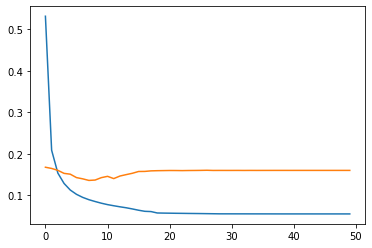

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
model = CausalLSTM(num_nodes=len(children), 
                   num_hiddens=16, 
                   children=children, 
                   child_input_idx=child_input_idx,
                   child_state_idx=child_state_idx,
                   input_len=10,
                   batch_size=batch_size)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=['mse'])
history = model.fit(train_x, np.squeeze(train_y), batch_size=batch_size, epochs=50,validation_split=0.2,callbacks=[checkpoint,lr])
y_pred_clstm = model.predict(test_x, batch_size=batch_size)

print('r2 of test dataset is {}'.format(r2_score(np.squeeze(y_pred_clstm), np.squeeze(test_y))))

Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 106s 44ms/sample - loss: 0.8239 - val_loss: 0.2107
Epoch 2/50
2400/2400 [==============================] - 8s 3ms/sample - loss: 0.1899 - val_loss: 0.1120
Epoch 3/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1203 - val_loss: 0.1078
Epoch 4/50
2400/2400 [==============================] - 8s 4ms/sample - loss: 0.1128 - val_loss: 0.1056
Epoch 5/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1095 - val_loss: 0.1026
Epoch 6/50
2400/2400 [==============================] - 8s 4ms/sample - loss: 0.1071 - val_loss: 0.0960
Epoch 7/50
2400/2400 [==============================] - 8s 4ms/sample - loss: 0.1054 - val_loss: 0.0898
Epoch 8/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1038 - val_loss: 0.0891
Epoch 9/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1032 - val_loss: 0.0857
Epoch 10/50
24

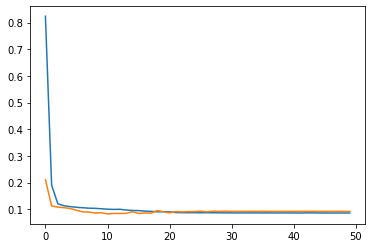

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [21]:
def unnormalized(inputs):
    return inputs*train_std[-1]+train_mean[-1]

y_pred_lstm = np.squeeze(unnormalized(y_pred_lstm))
y_pred_clstm = np.squeeze(unnormalized(y_pred_clstm))
y_pred_rf = np.squeeze(unnormalized(y_pred_rf))
y_test = np.squeeze(unnormalized(test_y))

In [22]:
OUT_PATH = '/work/lilu/CausalLSTM/figures/'

import os
if not os.path.exists(OUT_PATH + site_name):
    os.mkdir(OUT_PATH + site_name)

In [31]:
import netCDF4 as nc

dataset = nc.Dataset('/Users/lewlee/Desktop/ZA-Kru_2D_Fluxes_2001-2010.nc')
soil_moisture = dataset.variables['f_wliq_soisno'][:]
sm_lv1 = soil_moisture[-740:, 5, 0, 0][:700] # 0-0.0175m
sm_lv2 = soil_moisture[-740:, 6, 0, 0][:700] # 0.0175-(0.0175+0.0173)m
sm_lv3 = soil_moisture[-740:, 7, 0, 0][:700] # (0.0175+0.0173)-(0.0175+0.0173+0.0283)m

sm = (sm_lv1*1.75+sm_lv2*1.73+sm_lv3*2.83)/(1.75+1.73+2.83)


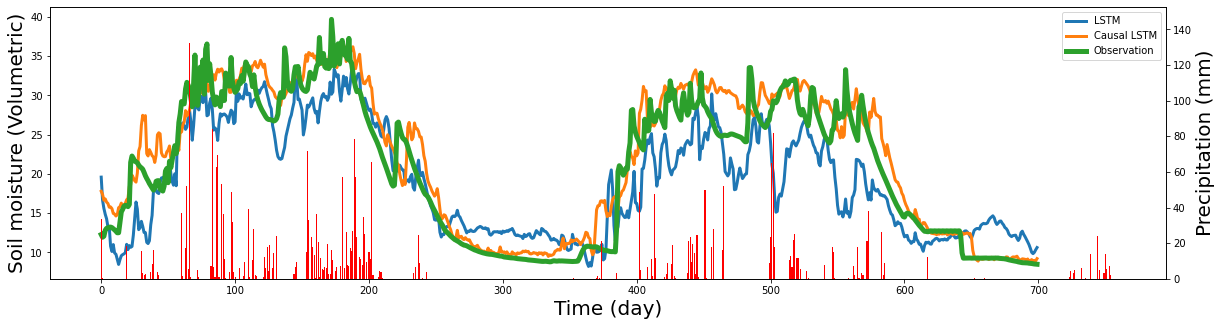

In [23]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111)
plt.plot(y_pred_lstm,linewidth=3)
plt.plot(y_pred_clstm, linewidth=3)
plt.plot(y_test, linewidth=5)
plt.legend(['LSTM','Causal LSTM','Observation'])
ax.set_xlabel('Time (day)', fontsize=20)
ax.set_ylabel('Soil moisture (Volumetric)', fontsize=20)

ax1 = ax.twinx()
test_df_ = test_df['P_F']*train_std['P_F']+train_mean['P_F']
test_df_ = np.array(test_df_[:1000])
ax1.bar(x=np.arange(len(np.array(test_df_))), height=np.array(test_df_), color='red')
ax1.set_ylim(0,max(test_df_)+20)

ax1.set_xlabel('Time (day)', fontsize=20)
ax1.set_ylabel('Precipitation (mm)', fontsize=20)

plt.savefig(OUT_PATH + site_name +'/time_series_'+site_name+'.pdf')

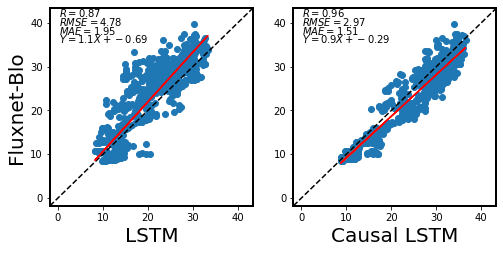

In [24]:
def linear_(x,y):
    a, b = np.polyfit(x, y, deg=1)
    y_est = a * x + b
    y_err = x.std() * np.sqrt(1/len(x) + (x - x.mean())**2 / np.sum((x - x.mean())**2))
    
    return y_est, y_err, a, b

y_est_lstm, y_err_lstm, a_lstm, b_lstm = linear_(np.squeeze(y_pred_lstm), np.squeeze(y_test))
y_est_clstm, y_err_clstm, a_clstm, b_clstm = linear_(np.squeeze(y_pred_clstm), np.squeeze(y_test))


min_, max_ = np.min(y_pred_lstm), np.max(y_pred_lstm)

plt.figure(figsize=(8,8))
ax1 = plt.subplot(221)
ax1.spines['top'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)

ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
ax1.scatter(y_pred_lstm, y_test)

ax1.plot(y_pred_lstm, y_est_lstm, '-', color='red')
ax1.fill_between(y_pred_lstm, y_est_lstm - y_err_lstm, y_est_lstm + y_err_lstm, alpha=0.2)
plt.xlim(min_-10,max_+10)
plt.ylim(min_-10,max_+10)
ax1.set_xlabel('LSTM',fontsize=20)
ax1.set_ylabel('Fluxnet-'+site_name,fontsize=20)
plt.text(min_-8,max_+8, '$R=%.2f$' % (pearsonr(np.squeeze(y_pred_lstm), np.squeeze(y_test))[0]))
plt.text(min_-8,max_+6, '$RMSE=%.2f$' % (np.sqrt(mean_squared_error(np.squeeze(y_pred_lstm), np.squeeze(y_test)))))
plt.text(min_-8,max_+4, '$MAE=%.2f$' % (np.sqrt(mean_absolute_error(np.squeeze(y_pred_lstm), np.squeeze(y_test)))))
plt.text(min_-8,max_+2, '$Y = %.1fX + %.2f$' % (a_lstm, b_lstm))

ax2 = plt.subplot(222)
ax2.spines['top'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

ax2.scatter(y_pred_clstm, y_test)
plt.xlim(min_-10,max_+10)
plt.ylim(min_-10,max_+10)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")

ax2.plot(y_pred_clstm, y_est_clstm, '-', color='red')
ax2.fill_between(y_pred_clstm, y_est_clstm - y_err_clstm, y_est_clstm + y_err_clstm, alpha=0.2)
ax2.set_xlabel('Causal LSTM',fontsize=20)
plt.text(min_-8,max_+8, '$R=%.2f$' % (pearsonr(np.squeeze(y_pred_clstm), np.squeeze(y_test))[0]))
plt.text(min_-8,max_+6, '$RMSE=%.2f$' % (np.sqrt(mean_squared_error(np.squeeze(y_pred_clstm), np.squeeze(y_test)))))
plt.text(min_-8,max_+4, '$MAE=%.2f$' % (np.sqrt(mean_absolute_error(np.squeeze(y_pred_clstm), np.squeeze(y_test)))))
plt.text(min_-8,max_+2, '$Y = %.1fX + %.2f$' % (a_clstm, b_clstm))

plt.savefig(OUT_PATH + site_name +'/scatter_'+site_name+'.pdf')